In [1]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP
from utils.visualizations import LRP, CLRP, LRPA, LRPB, LRPE
from utils.visualizations import SGLRP, SGLRPSeqA, SGLRPSeqB
from utils.helper import heatmap
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img

# limits tensorflow to a specific GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
# This will be your trained model instead.

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
model = VGG16(
    weights='imagenet'
)
# model.summary()

In [3]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
# Range of input images
# These values are set due to Keras Applications. Change this to a range suitable for your model.
max_input = 151.061
min_input = -123.68

In [5]:
# Change this to load a list of images you want. 
orig_imgs = [img_to_array(load_img("data/images/zebra_elephant{}.jpg".format(i+1), target_size=(224, 224))) for i in range(5)]
input_imgs = np.copy(orig_imgs)
print(np.shape(input_imgs))

# preprocess input for model
input_imgs = preprocess_input(input_imgs) #for built in keras models

(5, 224, 224, 3)


In [6]:
# Select only one from your list for example
example_id = 2

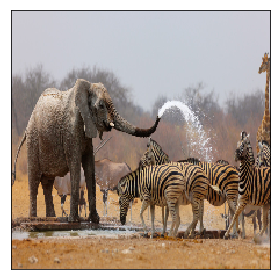

In [7]:
plt.imshow(orig_imgs[example_id].astype(int))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [8]:
# Which class you want to target.
target_class = 340 # ImageNet "zebra"

# GradCAM and GuidedGradCAM requires a specific layer
target_layer = "block5_pool" # VGG only

In [9]:
# Optional
predictions = model.predict(input_imgs)
pred_id = np.argmax(predictions[example_id])
print(decode_predictions(predictions))
print("prediction id:", pred_id)
print("target id:", target_class)

[[('n02391049', 'zebra', 0.6307453), ('n02504458', 'African_elephant', 0.3326331), ('n01871265', 'tusker', 0.023667239), ('n02504013', 'Indian_elephant', 0.010174592), ('n02437312', 'Arabian_camel', 0.0021476364)], [('n02391049', 'zebra', 0.7601926), ('n02504458', 'African_elephant', 0.14631793), ('n01871265', 'tusker', 0.025999784), ('n02408429', 'water_buffalo', 0.023420112), ('n02397096', 'warthog', 0.015506463)], [('n02391049', 'zebra', 0.996951), ('n02504458', 'African_elephant', 0.0011365646), ('n02437312', 'Arabian_camel', 0.0009571381), ('n02422699', 'impala', 0.00038000575), ('n01518878', 'ostrich', 0.000184144)], [('n02391049', 'zebra', 0.9992812), ('n01518878', 'ostrich', 0.00030275556), ('n02437312', 'Arabian_camel', 0.00014217473), ('n02422699', 'impala', 0.00012684488), ('n02423022', 'gazelle', 0.00011735351)], [('n02391049', 'zebra', 0.88132167), ('n02504458', 'African_elephant', 0.045931682), ('n01518878', 'ostrich', 0.02999202), ('n02423022', 'gazelle', 0.0062713153), 

In [10]:
use_relu = False

# GradCAM

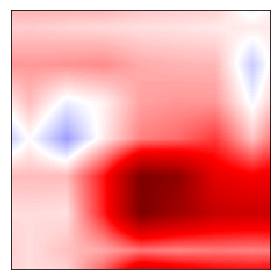

In [11]:
partial_gradcam_analyzer = GradCAM(
    model=partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=use_relu,
)
analysis_partial_grad_cam = partial_gradcam_analyzer.analyze(input_imgs)
heatmap(analysis_partial_grad_cam[example_id].sum(axis=(2)))
plt.show()

# Guided Back Propagation

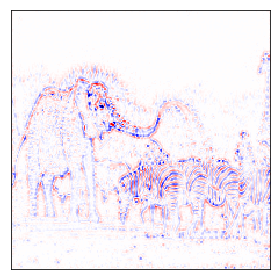

In [12]:
guidedbackprop_analyzer = GBP(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_guidedbackprop = guidedbackprop_analyzer.analyze(input_imgs)
heatmap(analysis_guidedbackprop[example_id].sum(axis=(2)))
plt.show()

# GuidedGradCAM

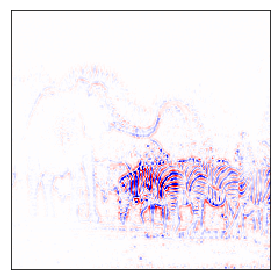

In [13]:
guidedgradcam_analyzer = GuidedGradCAM(
    partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=False,
)
analysis_guidedgradcam = guidedgradcam_analyzer.analyze(input_imgs)
heatmap(analysis_guidedgradcam[example_id].sum(axis=(2)))
plt.show()

# LRP

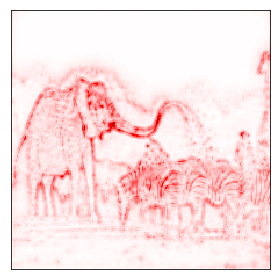

In [14]:
lrp_analyzer = LRP(
    partial_model,
    target_id=target_class,
    relu=use_relu,
    low=min_input,
    high=max_input,
)
analysis_lrp = lrp_analyzer.analyze(input_imgs)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()

# CLRP

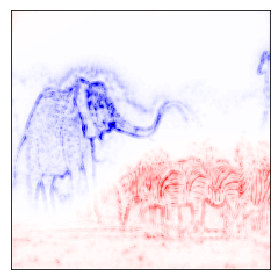

In [15]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=use_relu,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(input_imgs)
heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP

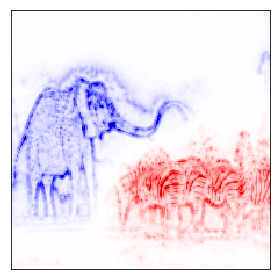

In [16]:
sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=use_relu,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(input_imgs)
heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP Sequential A

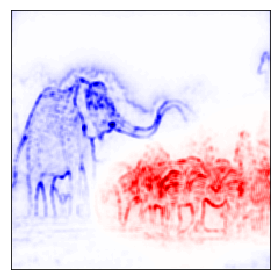

In [17]:
sglrpa_analyzer = SGLRPSeqA(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_sglrpa = sglrpa_analyzer.analyze(input_imgs)
heatmap(analysis_sglrpa[example_id].sum(axis=(2)))
plt.show()

# SGLRP Sequential B

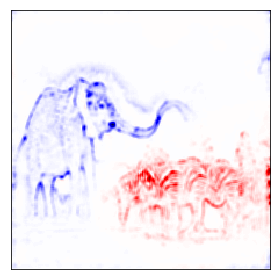

In [18]:
sglrpb_analyzer = SGLRPSeqB(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_sglrpb = sglrpb_analyzer.analyze(input_imgs)
heatmap(analysis_sglrpb[example_id].sum(axis=(2)))
plt.show()

# LRP Sequential A

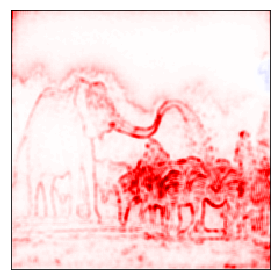

In [19]:
lrpa_analyzer = LRPA(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_lrpa = lrpa_analyzer.analyze(input_imgs)
heatmap(analysis_lrpa[example_id].sum(axis=(2)))
plt.show()

# LRP Sequential B

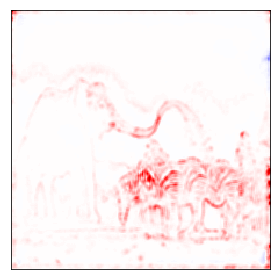

In [20]:
lrpb_analyzer = LRPB(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_lrpb = lrpb_analyzer.analyze(input_imgs)
heatmap(analysis_lrpb[example_id].sum(axis=(2)))
plt.show()

# LRP Epsilon

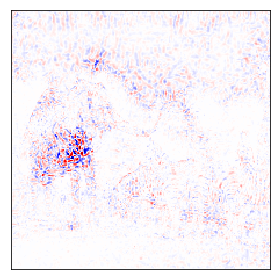

In [21]:
lrpe_analyzer = LRPE(
    partial_model,
    target_id=target_class,
    relu=use_relu,
)
analysis_lrpe = lrpe_analyzer.analyze(input_imgs)
heatmap(analysis_lrpe[example_id].sum(axis=(2)))
plt.show()